In [1]:
import numpy as np
from keras.datasets import mnist
from keras.utils import to_categorical
import matplotlib.pyplot as plt
np.random.seed(0)

In [2]:
class FcLayer:
    def __init__(self, input_size, output_size, l2=0):
        self.input = None
        self.output = None
        self.weights = np.random.randn(input_size, output_size) * np.sqrt(2 / input_size)  # He initialization
        self.biases = np.random.randn(1, output_size) * np.sqrt(2 / input_size)
        self.l2 = l2 # regularization

    def forward_propagation(self, input_data):
        self.input = input_data
        self.output = np.dot(self.input, self.weights) + self.biases
        return self.output

    def backward_propagation(self, output_error, learning_rate):
        input_error = np.dot(output_error, self.weights.T)
        weights_error = np.dot(self.input.T, output_error)
        self.weights -= learning_rate * (weights_error + self.l2 * self.weights)  # regularization
        self.biases -= learning_rate * output_error
        return input_error


class ActivationLayer:
    def __init__(self, activation="relu"):
        self.activation_dict = {"relu": [self.relu, self.relu_prime],
                                "leaky_relu": [self.leaky_relu, self.leaky_relu_prime],
                                "sigmoid": [self.sigmoid, self.sigmoid_prime],
                                "tanh": [self.tanh, self.tanh_prime]}
                                
        self.input = None
        self.output = None
        self.activation, self.activation_prime = self.activation_dict[activation]

    def forward_propagation(self, input_data):
        self.input = input_data
        self.output = self.activation(self.input)
        return self.output

    def backward_propagation(self, output_error, learning_rate):
        return self.activation_prime(self.input) * output_error

    def tanh(self, x):
        return np.tanh(x)

    def tanh_prime(self, x):
        return 1 - np.tanh(x) ** 2

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_prime(self, x):
        return self.sigmoid(x) * (1 - self.sigmoid(x))

    def relu(self, x):
        return x * (x > 0)

    def relu_prime(self, x):
        return 1. * (x > 0)

    def leaky_relu(self, x, alpha=0.01):
        return np.where(x > 0, x, alpha * x)

    def leaky_relu_prime(self, x, alpha=0.01):
        return np.where(x > 0, 1, alpha)


In [3]:
class FlattenLayer:
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def forward_propagation(self, input):
        return np.reshape(input, (1, -1))
    
    def backward_propagation(self, output_error, learning_rate):
        return np.reshape(output_error, self.input_shape)

In [4]:
class SoftmaxLayer:
    def __init__(self, input_size):
        self.input_size = input_size
    
    def forward_propagation(self, input):
        self.input = input
        tmp = np.exp(input)
        self.output = tmp / np.sum(tmp)
        return self.output
    
    def backward_propagation(self, output_error, learning_rate):
        input_error = np.zeros(output_error.shape)
        out = np.tile(self.output.T, self.input_size)
        return self.output * np.dot(output_error, np.identity(self.input_size) - out)

In [5]:
class NeuralNetwork:
    def __init__(self, layers=None):
        if layers is None:
            self.layers = []
        else:
            self.layers = layers
        self.loss = None
        self.loss_prime = None

    def add(self, layer):
        self.layers.append(layer)

    def use(self, loss_function):
        dict_loss = {"mse": [self.mse, self.mse_prime],
                     "binary_cross_entropy": [self.binary_cross_entropy, self.binary_cross_entropy_prime],
                     "categorical_cross_entropy":[self.categorical_cross_entropy, self.categorical_cross_entropy_prime]}
        self.loss, self.loss_prime = dict_loss[loss_function]

    def predict(self, input_data):
        result = []
        for i in range(len(input_data)):
            output = input_data[i]
            for layer in self.layers:
                output = layer.forward_propagation(output)
            result.append(output)
        return result

    def fit(self, x_train, y_train, epochs, learning_rate):
        samples = len(x_train)
        for i in range(epochs):
            err = 0
            for j in range(samples):
                output = x_train[j]
                for layer in self.layers:
                    output = layer.forward_propagation(output)
                err += self.loss(y_train[j], output)

                error = self.loss_prime(y_train[j], output)
                for layer in reversed(self.layers):
                    error = layer.backward_propagation(error, learning_rate)
            err /= samples
            print(f'epoch {i+1}/{epochs}   error={err}')

    def mse(self, y_true, y_pred):
        return np.square(y_true - y_pred)

    def mse_prime(self, y_true, y_pred):
        return 2 * (y_pred - y_true)

    def binary_cross_entropy(self, y_true, y_pred):
        epsilon = np.finfo(float).eps
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        return -(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

    def binary_cross_entropy_prime(self, y_true, y_pred):
        epsilon = np.finfo(float).eps
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        return (y_pred - y_true) / (y_pred * (1 - y_pred))
    
    def categorical_cross_entropy(self, y_true, y_pred):
        epsilon = np.finfo(float).eps
        y_pred = np.clip(y_pred, epsilon, 1. - epsilon)
        loss = -np.sum(y_true * np.log(y_pred))
        return loss

    def categorical_cross_entropy_prime(self, y_true, y_pred):
        epsilon = np.finfo(float).eps
        y_pred = np.clip(y_pred, epsilon, 1. - epsilon)
        return -y_true / y_pred #y_pred - y_true 

In [6]:
x_train = np.array([[[0, 0]], [[0, 1]], [[1, 0]], [[1, 1]]])
y_train = np.array([[[0]], [[1]], [[1]], [[0]]])

# network
net = NeuralNetwork()
net.add(FcLayer(2, 5))
net.add(ActivationLayer("leaky_relu"))
net.add(FcLayer(5, 1))
net.add(ActivationLayer("sigmoid"))

# train
net.use("mse")
net.fit(x_train, y_train, epochs=10000, learning_rate=0.1)

# test
out = net.predict(x_train)
print(out)

epoch 1/10000   error=[[0.30969372]]
epoch 2/10000   error=[[0.30657729]]
epoch 3/10000   error=[[0.30363577]]
epoch 4/10000   error=[[0.30085893]]
epoch 5/10000   error=[[0.29821067]]
epoch 6/10000   error=[[0.29549229]]
epoch 7/10000   error=[[0.29275988]]
epoch 8/10000   error=[[0.29001888]]
epoch 9/10000   error=[[0.28723367]]
epoch 10/10000   error=[[0.28437446]]
epoch 11/10000   error=[[0.28141662]]
epoch 12/10000   error=[[0.27834002]]
epoch 13/10000   error=[[0.27512822]]
epoch 14/10000   error=[[0.27176783]]
epoch 15/10000   error=[[0.26824798]]
epoch 16/10000   error=[[0.26455992]]
epoch 17/10000   error=[[0.26091737]]
epoch 18/10000   error=[[0.25736868]]
epoch 19/10000   error=[[0.25374851]]
epoch 20/10000   error=[[0.25004813]]
epoch 21/10000   error=[[0.2462641]]
epoch 22/10000   error=[[0.24239688]]
epoch 23/10000   error=[[0.2384499]]
epoch 24/10000   error=[[0.23442887]]
epoch 25/10000   error=[[0.23034129]]
epoch 26/10000   error=[[0.22619614]]
epoch 27/10000   error=

In [7]:
#2x-1

x_train = np.array([[1], [2], [3], [4], [5]])
y_train = np.array([[1], [3], [5], [7], [9]])

net = NeuralNetwork()
net.add(FcLayer(1, 20, l2=0.01))
net.add(ActivationLayer("leaky_relu"))
net.add(FcLayer(20, 1, l2=0.01))

net.use("mse")
net.fit(x_train, y_train, epochs=1000, learning_rate=0.001)

out = net.predict(np.array([[7]]))
print(out)

epoch 1/1000   error=[[23.63648904]]
epoch 2/1000   error=[[0.3841635]]
epoch 3/1000   error=[[0.27312591]]
epoch 4/1000   error=[[0.2630415]]
epoch 5/1000   error=[[0.25163214]]
epoch 6/1000   error=[[0.2409442]]
epoch 7/1000   error=[[0.2308849]]
epoch 8/1000   error=[[0.22141735]]
epoch 9/1000   error=[[0.21250563]]
epoch 10/1000   error=[[0.20411604]]
epoch 11/1000   error=[[0.19621692]]
epoch 12/1000   error=[[0.18877852]]
epoch 13/1000   error=[[0.18177289]]
epoch 14/1000   error=[[0.17517374]]
epoch 15/1000   error=[[0.16895639]]
epoch 16/1000   error=[[0.16309765]]
epoch 17/1000   error=[[0.1575757]]
epoch 18/1000   error=[[0.15237007]]
epoch 19/1000   error=[[0.14746148]]
epoch 20/1000   error=[[0.14283185]]
epoch 21/1000   error=[[0.13846417]]
epoch 22/1000   error=[[0.13434245]]
epoch 23/1000   error=[[0.1304517]]
epoch 24/1000   error=[[0.12677778]]
epoch 25/1000   error=[[0.12330746]]
epoch 26/1000   error=[[0.12002828]]
epoch 27/1000   error=[[0.11692854]]
epoch 28/1000  

In [8]:
x_train = np.array([[[0, 0]], [[0, 1]], [[1, 0]], [[1, 1]]])
y_train = np.array([[[0]], [[1]], [[1]], [[0]]])

net = NeuralNetwork([FcLayer(2, 5),
                     ActivationLayer("leaky_relu"),
                     FcLayer(5, 1),
                     ActivationLayer("sigmoid")])

net.use("mse")
net.fit(x_train, y_train, epochs=10000, learning_rate=0.1)

out = net.predict(x_train)
print(out)

epoch 1/10000   error=[[0.39332353]]
epoch 2/10000   error=[[0.345237]]
epoch 3/10000   error=[[0.30603547]]
epoch 4/10000   error=[[0.29057974]]
epoch 5/10000   error=[[0.28558629]]
epoch 6/10000   error=[[0.28337307]]
epoch 7/10000   error=[[0.28162127]]
epoch 8/10000   error=[[0.27979388]]
epoch 9/10000   error=[[0.27791098]]
epoch 10/10000   error=[[0.27607923]]
epoch 11/10000   error=[[0.27455314]]
epoch 12/10000   error=[[0.2727643]]
epoch 13/10000   error=[[0.27168602]]
epoch 14/10000   error=[[0.26998974]]
epoch 15/10000   error=[[0.26840896]]
epoch 16/10000   error=[[0.26677148]]
epoch 17/10000   error=[[0.26572042]]
epoch 18/10000   error=[[0.26434349]]
epoch 19/10000   error=[[0.26214014]]
epoch 20/10000   error=[[0.2610264]]
epoch 21/10000   error=[[0.25970475]]
epoch 22/10000   error=[[0.25803822]]
epoch 23/10000   error=[[0.2567573]]
epoch 24/10000   error=[[0.25423672]]
epoch 25/10000   error=[[0.25331782]]
epoch 26/10000   error=[[0.25176728]]
epoch 27/10000   error=[[0

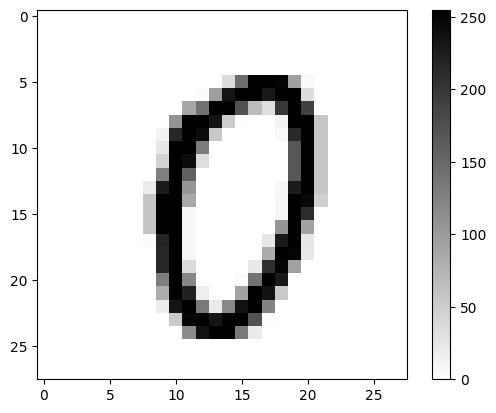

In [9]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
plt.imshow(train_images[1000], cmap="binary")
plt.colorbar()

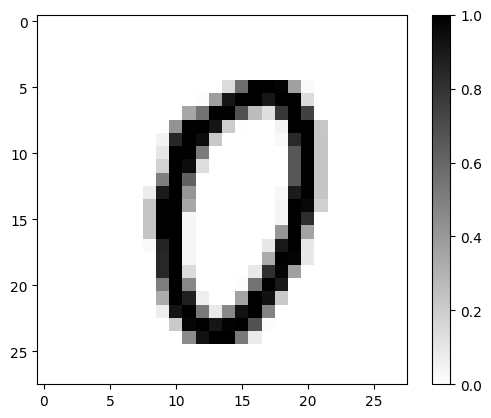

In [10]:
train_images = train_images.astype("float32")
train_images = train_images / 255.0
train_labels = to_categorical(train_labels)

test_images = test_images.astype("float32")
test_images = test_images / 255.0
test_labels = to_categorical(test_labels)
plt.imshow(train_images[1000], cmap="binary")
plt.colorbar()

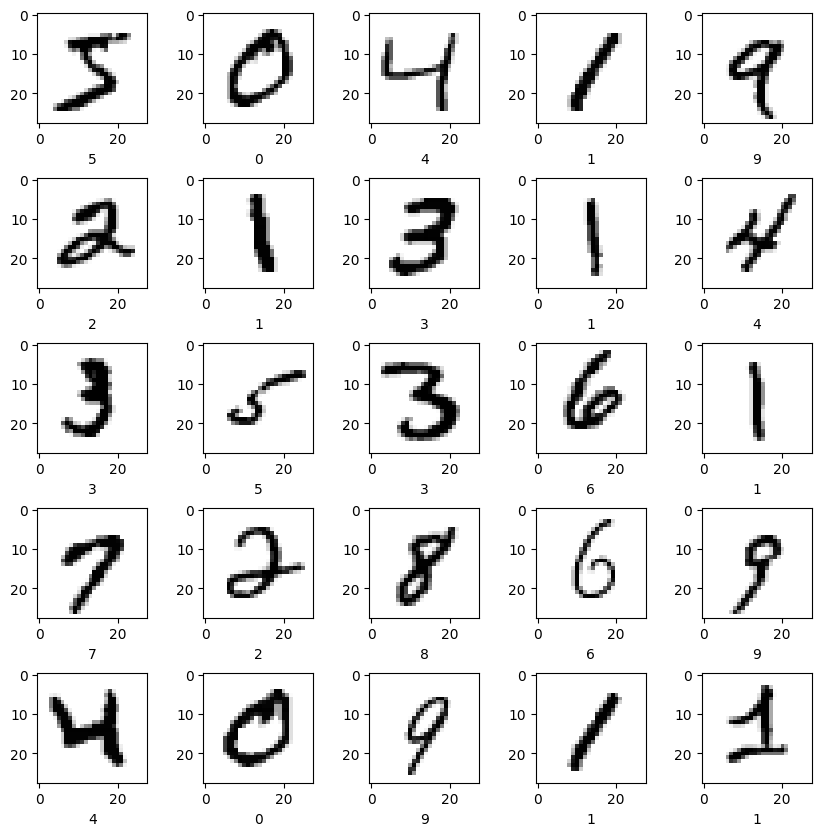

In [11]:
plt.figure(figsize=(10,10))
plt.subplots_adjust(hspace=0.5, wspace=0.5)
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(train_images[i], cmap="binary")
    plt.xlabel(np.argmax(train_labels[i]))
plt.show()

In [12]:
model = NeuralNetwork([FlattenLayer(input_shape=(28, 28)),
                       FcLayer(28*28,128, l2=0.001),
                       ActivationLayer("relu"),
                       FcLayer(128,10, l2=0.001),
                       SoftmaxLayer(10)])
model.use("categorical_cross_entropy")
train_images = train_images[:1000]
train_labels = train_labels[:1000]
model.fit(train_images, train_labels, epochs=100, learning_rate=0.01)

epoch 1/100   error=0.967984134066106
epoch 2/100   error=0.41931239731254255
epoch 3/100   error=0.2907852030134413
epoch 4/100   error=0.2091511258885233
epoch 5/100   error=0.1529450839598395
epoch 6/100   error=0.11358255349347167
epoch 7/100   error=0.08509254969680105
epoch 8/100   error=0.0648001100703977
epoch 9/100   error=0.05124816036694736
epoch 10/100   error=0.04210489977965894
epoch 11/100   error=0.03571993698917863
epoch 12/100   error=0.03131133515563114
epoch 13/100   error=0.02787730372955617
epoch 14/100   error=0.02526786750375681
epoch 15/100   error=0.02329105220307457
epoch 16/100   error=0.021624249723527857
epoch 17/100   error=0.0203028936813919
epoch 18/100   error=0.019219815961474405
epoch 19/100   error=0.01831392487773347
epoch 20/100   error=0.017526330677784183
epoch 21/100   error=0.016885016888263743
epoch 22/100   error=0.016330824226196736
epoch 23/100   error=0.01585348469008227
epoch 24/100   error=0.015423983183145409
epoch 25/100   error=0.015

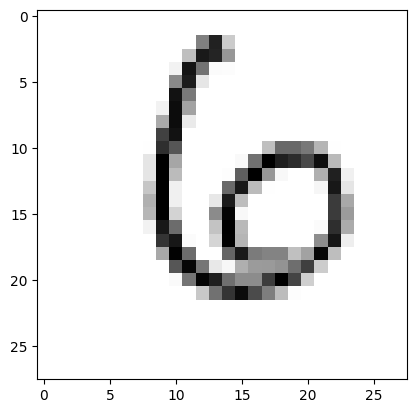

Prediction: 6, Propability: 0.983, True result: 6


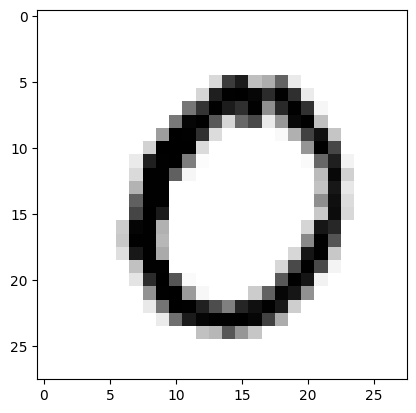

Prediction: 0, Propability: 0.995, True result: 0


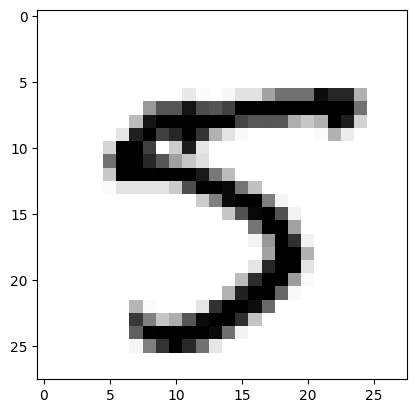

Prediction: 5, Propability: 0.998, True result: 5


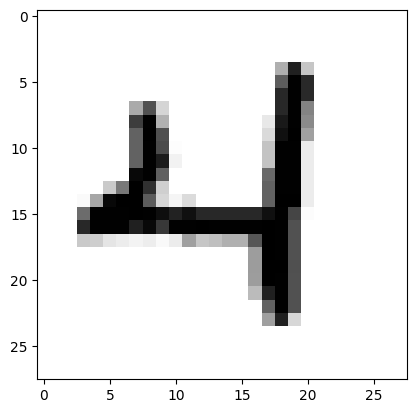

Prediction: 4, Propability: 0.999, True result: 4


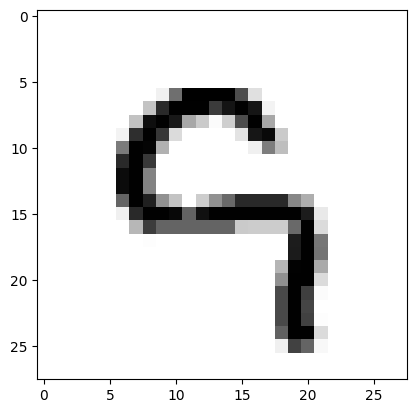

Prediction: 9, Propability: 0.596, True result: 9


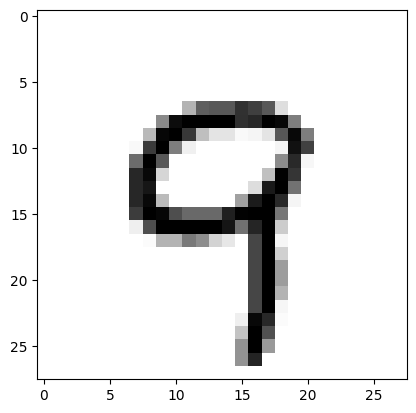

Prediction: 9, Propability: 0.993, True result: 9


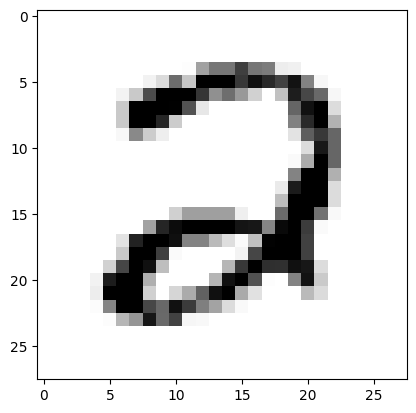

Prediction: 2, Propability: 0.993, True result: 2


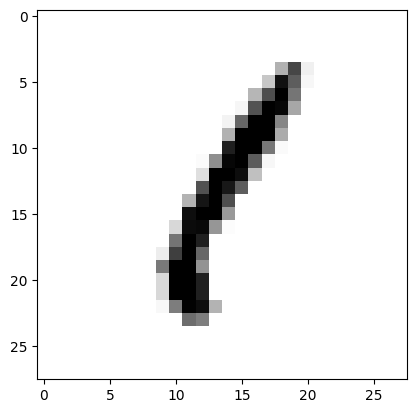

Prediction: 1, Propability: 0.911, True result: 1


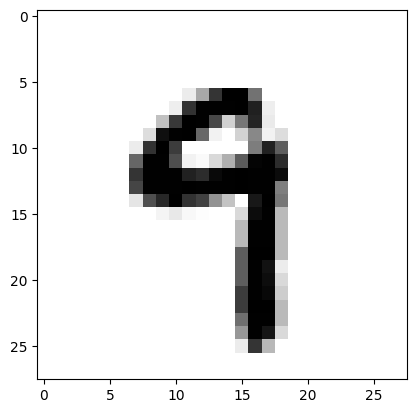

Prediction: 9, Propability: 0.995, True result: 9


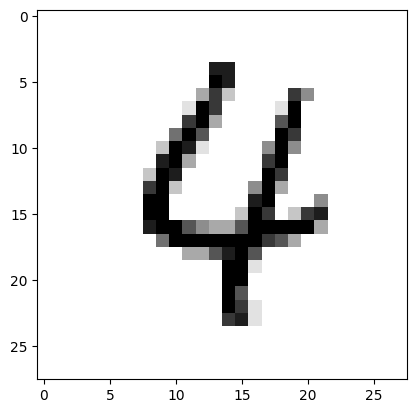

Prediction: 4, Propability: 0.958, True result: 4


In [13]:
left = 100
right = 110
for i in range(left, right):
    image = np.reshape(test_images[i], (28, 28))
    plt.imshow(image, cmap='binary')
    plt.show()
    pred = model.predict([image])[0]
    idx = np.argmax(pred)
    idx_true = np.argmax(test_labels[i]) 
    print(f"Prediction: {idx}, Propability: {round(pred[0,idx],3)}, True result: {idx_true}")